In [1]:
# code aangepast van https://www.philschmid.de/bert-text-classification-in-a-different-language
!ipython kernel install --user --name DataLabDisc
!which jupyter
!pip list

Installed kernelspec DataLabDisc in /data/milenadeswart/.local/share/jupyter/kernels/datalabdisc
/data/anaconda3/bin/jupyter
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package                            Version
---------------------------------- -----------
absl-py                            2.1.0
aiohttp                            3.8.6
aiosignal                          1.3.1
alabaster                          0.7.12
alembic                            1.6.5
altair                             5.0.1
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
appdirs                            1.4.4
asn1crypto                         1.0.1
astroid                            2.3.1
astropy                            3.2.2
async-generator                    1.10
async-timeout             

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
import warnings
warnings.filterwarnings('ignore')

In [3]:
# check device waarop de code runt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

In [ ]:
# inladen & mergen data
def merge_annotated_data(naam_dataset, n_annotators, n_annotations = 3):
    """ functie die de gesplitste data gesplitst door split_annotated_data weer kan samenvoegen.
    De datasets met de naam naam_dataset_n_annotators.csv worden ingeladen. Vervolgens wordt de oorspronkelijke dataset gereconstrueerd
    uit de ingeladen data. De oorspronkelijke zinnen en het overzicht van de labels wordt gereturned.

    Input:
    naam_dataset: str, de naam van de documenen die de annotators hebben ingevuld
    n_annotators: int, het aantal annotators
    n_annotations: int, het aantal annotations per zin. default 3

    Output:
    merged_data: een DataFrame met daarin de oorspronkelijke data en de n_annotations labels die zijn toegekend.
    """
    # inladen path naar data en creëren lege frames
    dataset_path = "~/Projecten/programma-discriminatie-en-racisme/datasets/Datasets_2/"
    merged_data = pd.DataFrame()

    for i in range(n_annotators):
        # inladen annotated documenten en samenvoegen
        annotated_doc = pd.read_excel(dataset_path + naam_dataset + "_" + str(i) + '.xlsx')
        annotated_doc = annotated_doc.dropna(subset=['Label', 'text', 'Column1'])
        columns = list(annotated_doc.columns)

        #display(annotated_doc)

        # document opstellen
        if i == 0:
            merged_data = annotated_doc
        else:
            merged_data = pd.concat([merged_data, annotated_doc])

    display(merged_data)

    merged_data = merged_data.groupby(['Column1']).agg({'id': 'last', 'titel': 'last', 'text': 'last', 'zin': 'last', 'Label': 'mean'})
    #merged_data = merged_data.sort_values(by = ['Column1'])

    return pd.DataFrame(merged_data)

merged = merge_annotated_data('te_labellen', n_annotators = 8, n_annotations = 3)

display(merged)

In [ ]:
# bekijken dataset
print(merged.columns)

pos = len(merged[merged.Label == 1.0])
neg = len(merged[merged.Label==0.0])
unclear = len(merged[merged.Label==4.0])
useless = len(merged[merged.Label==7.0])

print(f"The dataset has {pos} biased and {neg} unbiased instances for a total of {pos+neg}. There are {unclear} unclear labels.")

In [7]:
# prepareer dataset voor inladen in model
merged = merged[merged.Label < 4.0] # behoud alleen labels 1 en 0

merged = merged.drop(columns = ['id', 'titel', 'zin'])
merged = merged.rename(columns={"Label": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df = train_test_split(merged, test_size=0.20)
train_df, val_df = train_test_split(train_val_df, test_size=0.25)

print(len(train_df), len(val_df), len(test_df))

1779 593 594


In [10]:
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False, # vorm van de input van de data
             "silent": False, # zeker weten dat progress bars worden geprint
             "use_multiprocessing": False, # versnelt training
             "use_multiprocessing_for_evaluation": False, # versnelt training
             "overwrite_output_dir": False, # niet ieder model opslaan
             "save_total_limit": 2, # slaat meest recente en beste epoch op
             "save_strategy": 'no', # niet tussentijds opslaan
             "load_best_model_at_end": False, # niet het beste model inladen (dat kan niet door opsla-instellingen)
             "num_train_epochs": 5, # hoeveel epochs
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"steps", # slaat een tussentijds model op om te evalueren
            "eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 24, # batch size trainingsdata
            "eval_batch_size": 24} # batch size validation data

# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert-base-dutch-cased", # Nederlands!!
    #"bert", "bert-base-uncased", # English!!
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    use_cuda=False # omdat dit op de cpu draait
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'bert.

In [11]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/75 [00:00<?, ?it/s]

In [12]:
# testen
from sklearn.metrics import f1_score, accuracy_score

# om f1 te kunnen genereren
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)


Running Evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

{'mcc': 0.3804325375972074, 'tp': 33, 'tn': 476, 'fp': 22, 'fn': 63, 'auroc': 0.8051999665327978, 'auprc': 0.48399945806103417, 'f1': 0.6775594398002389, 'acc': 0.8569023569023569, 'eval_loss': 0.7593391788750887}


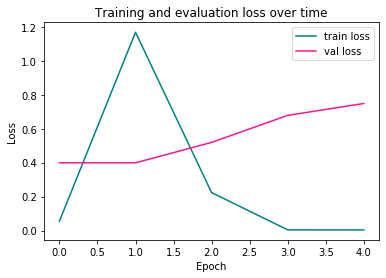

In [14]:
# maak een plotje van de loss
train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [15]:
print(train_results)

(375, defaultdict(<class 'list'>, {'global_step': [75, 150, 225, 300, 375], 'train_loss': [0.055035557597875595, 1.1680638790130615, 0.2238083928823471, 0.00414998410269618, 0.003763132030144334], 'mcc': [0.3464477196669204, 0.402463414892708, 0.4052040738659553, 0.3611392055217786, 0.35981091043115754], 'tp': [24, 35, 46, 38, 30], 'tn': [480, 472, 453, 459, 473], 'fp': [10, 18, 37, 31, 17], 'fn': [79, 68, 57, 65, 73], 'auroc': [0.7738953833960769, 0.8005250643946898, 0.7824351099663166, 0.7635724192589657, 0.7550326926887261], 'auprc': [0.5293161772882675, 0.5729402223493186, 0.5508289447368235, 0.5348510967303476, 0.5323360100448771], 'eval_loss': [0.39917704641819, 0.39893104195594786, 0.5192696335166693, 0.678456740155816, 0.7484239959204569]}))


In [ ]:
print(wrong_predictions)

In [ ]:
model.evaluate(eval_df = val_df) #, output_dir = output_dir)

In [18]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

class_names = ['0', '1']

text = 'Building more bypasses will help the environment by reducing pollution and traffic jams in towns and cities.'
print(tokenizer(text, return_tensors='pt', padding=True))

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, model, num_features=20, num_samples=2000)
exp.show_in_notebook(text=text)

{'input_ids': tensor([[    1,  1521, 15800,   117, 10031, 27707,   117,   131, 22482,   124,
         13177, 20049, 11281, 29448, 28236, 27106, 10031, 18070, 29167, 26208,
         17586, 29265,  8470, 20271, 25262,   115, 13912,   125,   131, 13644,
         20125,   135,   126,   131,  8470, 10156, 28999,    13,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


TypeError: 'ClassificationModel' object is not callable

In [ ]:
# OUDE/ANDERE CODE

In [ ]:
#dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
#dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})
print(dataset.columns)


X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [ ]:
#tokenized_train = tokenizer(dataset['train']["text"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
#tokenized_data = dict(tokenized_train)
                     
#labels_train = np.array(dataset['train']["label"])  # Label is already an array of 0 and 1)

In [ ]:
# trainen
# sla training_arguments op
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    reprocess_input_data= True,
    fp16=False,
    overwrite_output_dir = True
)

metric = evaluate.load("accuracy")

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# train model!
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
# maak dataset correcte format: [{'label': value, 'text': text}, {'label': value, 'text': text}]
data = []

for i in range(len(dataset_zoek)):
    label = dataset_zoek['totaalscore'].iloc[i]
    text = dataset_zoek['zin'].iloc[i]
    tokenized_text = tokenizer(str(text), return_tensors="np", padding=True)
    duo = {'label': label, 'text': tokenized_text}
    data.append(duo)
    
print(len(data))

In [ ]:
# split dataset: 60% train, 20% val, 20% test
trainval, test = train_test_split(data, train_size = 0.8)
train, val = train_test_split(trainval, train_size = 0.75)

print(len(train), len(val), len(test))

In [ ]:
train_labels = []

for item in train:
    train_labels.append(item['label'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

# Read data
dataset_zoek = pd.read_csv(dataset_path + 'dataset_dummy.csv', sep = ',') # model is te groot om te trainen met volledige dataset zonder GPU
dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})

# Define pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)



In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
# ----- 3. Predict -----#
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["review"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-50000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
ds = Dataset.from_pandas(dataset)

print(ds)

# split dataset: 60% train, 20% val, 20% test
train_testvalid = ds.train_test_split(test_size=0.4)
# Split the 40% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds['train']['text'][100])

In [ ]:
def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=True,
        tokenizer=None, 
        topic=None, 
        freeze_bert = None, 
        num_feats=None, 
        keep_stopwords = None,
        combined_feats = None, 
        sum_layers = None
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

       
        combined_feats=aggregate_features(outputs, tokenizer, input_ids, topic, 
                                     num_feats, keep_stopwords, sum_layers).to(device)
        combined_feats = self.dropout(combined_feats)
        logits = self.classifier(combined_feats)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )